<a href="https://colab.research.google.com/github/sanaomaro/5002-1/blob/main/NM_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>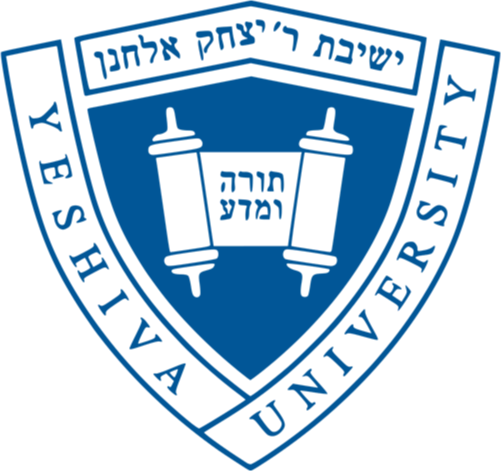</center>

# <center>Katz School of Science and Health</center>
# <center>AIM 5003 Numerical Methods</center>
<br>

# <center>Project 3: Real-time Face Recognition using the SVD</center>
<br><br>

### <center>Radek Jan Holik</center>
### <center>Sana Omar</center>
<!-- ### <center>Rivka Shapiro</center>



# <a name="Contents">Table of Contents</a>
- [1 Loding Data](#Section-1)
    - [1.1 Import the Necessary Libraries](#Section-11)
    - [1.2 Data Links](#Section-12)
    - [1.3 Loading Addresses of All Images](#Section-13)
    - [1.4 Load Image Files](#Section-14)
    - [1.5 Size of One Image](#Section-15)
    - [1.6 Sample of Images](#Section-16)
<p>

- [2 Data Set](#Section-2)
    - [2.1 Definition of 'img2vec'](#Section-21)
    - [2.2 Definition of 'vec2img'](#Section-22)
    - [2.3 Definition of 'img2mat'](#Section-23)
    - [2.4 Conversion of all Faces to Vectors](#Section-24)
    - [2.5 Mean Face $\bar{f}$](#Section-25)
    - [2.6 Normalization of the Data Set](#Section-26)
<p>

- [3 Division of the Data Set](#Section-3)
    - [3.1 Definition of 'shuffle'](#Section-31)
    - [3.2 Shuffling the Original Data Set](#Section-32)
    - [3.3 Dataset Shuffling Check](#Section-33)
    - [3.4 Dividing Ratio](#Section-34)
    - [3.5 Two Disjoint Sets $F$ and $Q$](#Section-35)
<p>

- [4 Face Recognition in the Original Image Space](#Section-4)
    - [4.1 Definition of 'query'](#Section-41)
    - [4.2 Definition of 'recognition'](#Section-42)
    - [4.3 One Face Recognition](#Section-43)
    - [4.4 Several Face Recognitions](#Section-44)
<p>
    
- [5 Recognition of each Image in $Q$](#Section-5)
    - [5.1 Original Ratio 75:25 between $F$ and $Q$](#Section-51)
    - [5.2 Ration 80:20 between $F$ and $Q$](#Section-52)
    - [5.3 Ration 60:40 between $F$ and $Q$](#Section-53)
    - [5.4 Comparison of Individual Ratios](#Section-54)
<p>

 - [6 Singular Value Decomposition (SVD)](#Section-6)
    - [6.1 Original Ratio between F and Q](#Section-61)
    - [6.2 SVD Calculation](#Section-62)
    - [6.3 Sanity Check on Dimensions](#Section-63)
    - [6.4 Eigen Faces](#Section-64)
<p>

- [7 Selection of the Dimension $p$](#Section-7)
    - [7.1 Distribution of Singular Values](#Section-71)
    - [7.2 Value of $p$](#Section-72)
<p>

- [8 Projection on the Reduced Face Space](#Section-8)
    - [8.1 Base-Face](#Section-81)
    - [8.2 Projection of the Database $F$](#Section-82)
    - [8.3 Projection of the Query Set $Q$](#Section-83)
    - [8.4 Recognition of the Reduced $Q$](#Section-84)
    - [8.5 One Face Recognition of the reduced $Q$](#Section-85)
    - [8.6 Accuracy Based on $p$](#Section-86)
<p>

- [9 Conclusion](#Section-9)
<p>

- [10 Extra Activities](#Section-10)
<p>

- [References](#Section-8)

# <a name="Section-1"> 1 Loding Data</a>
[top](#Contents)

## <a name="Section-11">1.1 Import the Necessary Libraries</a>

In [ ]:
# Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

from bs4 import BeautifulSoup
import requests
import re
import PIL
import urllib
import dask.array as da

import time
from datetime import timedelta

import tracemalloc

# Setup printing numbers in scientific notation with a high accuracy
np.set_printoptions(suppress = False)
np.set_printoptions(precision = 16)

import warnings
warnings.filterwarnings("ignore")

## <a name="Section-12">1.2 Data Links</a>

In [ ]:
pathUrl = r"https://github.com/rjholik/AIM-5003-Numerical-Methods/tree/main/Projects/03/yaledatabase"
filePath = r"https://raw.githubusercontent.com/rjholik/AIM-5003-Numerical-Methods/main/Projects/03/yaledatabase"

## <a name="Section-13">1.3 Loading Addresses of All Images</a>

In [ ]:
def getNames(url):
    '''
        Return a list of file names from the path way.
    '''
    my_regex = re.compile("\w\d+[\.]\w")
    
    
    response = requests.get(url)
    if response.ok:
        responseText = response.text
    else:
        return response.raise_for_status()
    
    soup = BeautifulSoup(responseText, 'html.parser')
    
    parent = [node for node in soup.find_all(text = my_regex)]
    
    return parent

In [ ]:
files = getNames(pathUrl)

## <a name="Section-14">1.4 Load Image Files</a>

In [ ]:
def getGifFiles(url, files):
    '''
        Clean Data (load, normalize, tokenize, remove punctuation, split, remove stopwords)
    '''
    
    myGifs = []
    
    for file in files:
        path = url + "/" + file
        
        # Load one gif file
        gif = np.array(PIL.Image.open(urllib.request.urlopen(path)))
        
        myGifs.append(gif)
        
    return myGifs

In [ ]:
gifs = getGifFiles(filePath, files)

N = len(gifs)
print(f"Image count : N = {N}")

## <a name="Section-15">1.5 Size of One Image</a>

In [ ]:
shapeImage = gifs[0].shape
print(f"The size of one picture : {shapeImage}")

The size of one picture : (243, 320)


## <a name="Section-16">1.6 Sample of Images</a>

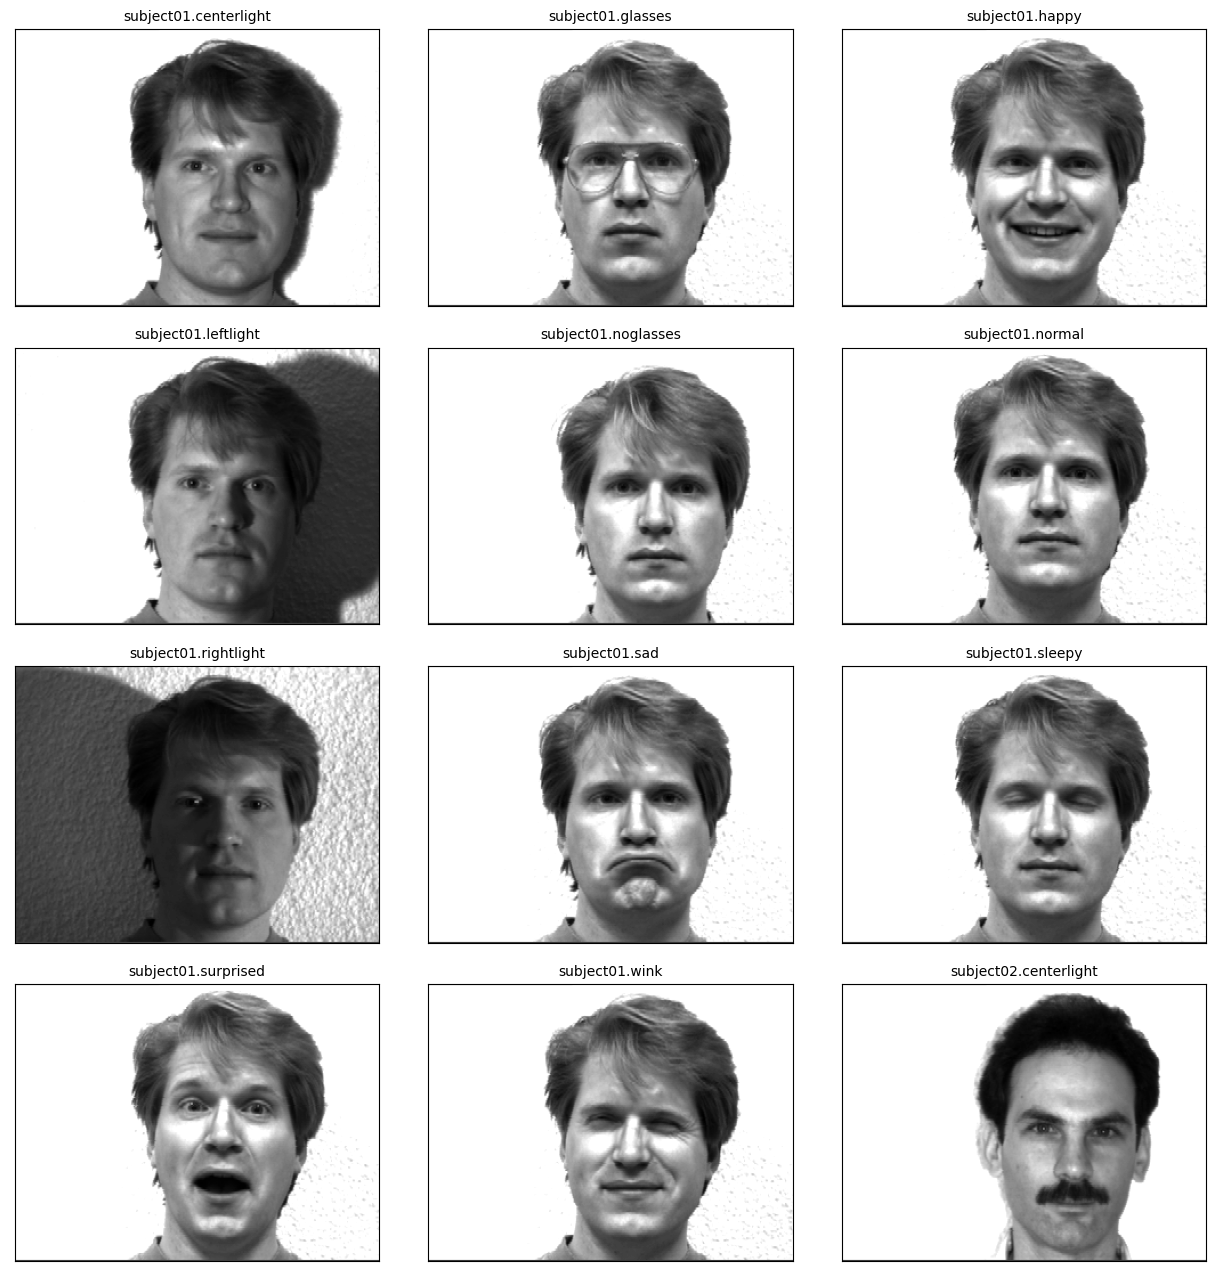

In [ ]:
plt.figure(figsize = (16, 16))
for img in range(0, 12):
    plt.subplot(4, 3, img + 1)
    plt.imshow(gifs[img], cmap = "gray")
    plt.title(files[img], fontsize = 10)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace=0, hspace=0.15)

# <a name="Section-2">2 Data Set</a>
[top](#Contents)

## <a name="Section-21">2.1 Definition of 'img2vec'</a>

In [ ]:
def img2vec(face):
    M = face.shape[0] * face.shape[1]
    vec = face.reshape(M, 1)

    return vec

## <a name="Section-22">2.2 Definition of 'vec2img'</a>

In [ ]:
def vec2img(image, dimension = (243, 320)):
    return image.reshape(dimension)

## <a name="Section-23">2.3 Definition of 'img2mat'</a>

In [ ]:
def img2mat(faces):
    
    for idx, face in enumerate(faces):
        vec = img2vec(face)

        if idx == 0:
            S = vec
        else:
            S = np.concatenate((S, vec), axis=1)

    return S

## <a name="Section-24">2.4 Conversion of all Faces to Vectors</a>

In [ ]:
dataSet = img2mat(gifs)

# dataSet dimension
print(f"dataSet : {dataSet.shape}")

dataSet : (77760, 165)


## <a name="Section-25">2.5 Mean Face $\bar{f}$</a>

In [ ]:
fBar = (dataSet.sum(axis = 1) / N).reshape(dataSet.shape[0], 1)

# fBar dimension
print(f"fBar : {fBar.shape}")

fBar : (77760, 1)


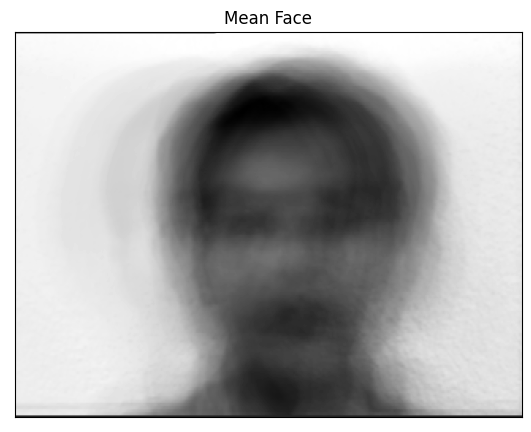

In [ ]:
plt.figure(figsize = (9, 5))
plt.imshow(vec2img(fBar), cmap = "gray")
plt.title('Mean Face')
plt.xticks([])
plt.yticks([])
plt.show()

## <a name="Section-26">2.6 Normalization of the Data Set</a>

In [ ]:
# Matrix A
A = dataSet - np.multiply(fBar, np.ones(dataSet.shape))

# A dimension
print(f"A : {A.shape}")

A : (77760, 165)


# <a name="Section-3">3 Division of the Data Set</a>
[top](#Contents)

## <a name="Section-31">3.1 Definition of 'shuffle'</a>

In [ ]:
def shuffle(gifs, files):
    np.random.seed(2022)
    
    #Shuffle two lists with same order
    temp = list(zip(gifs, files))

    # 5 times shuffling
    for _ in range(5):
        np.random.shuffle(temp)

    res1, res2 = zip(*temp)
    gifs, files = list(res1), list(res2)

    return np.array(gifs).T, files

## <a name="Section-32">3.2 Shuffling the Original Data Set</a>

#### __To avoid an uneven distribution of suspects between individual sets, we "precisely" shuffle the data set.__

In [ ]:
A_shuffled, files_shuffled = shuffle([A[:,idx] for idx in range(A.shape[1])], files)

## <a name="Section-33">3.3 Dataset Shuffling Check</a>

#### __The following checking sample of the suspects from the beginning of the data set shows that no single suspect is recurring in the series or more frequent than the other suspects.__

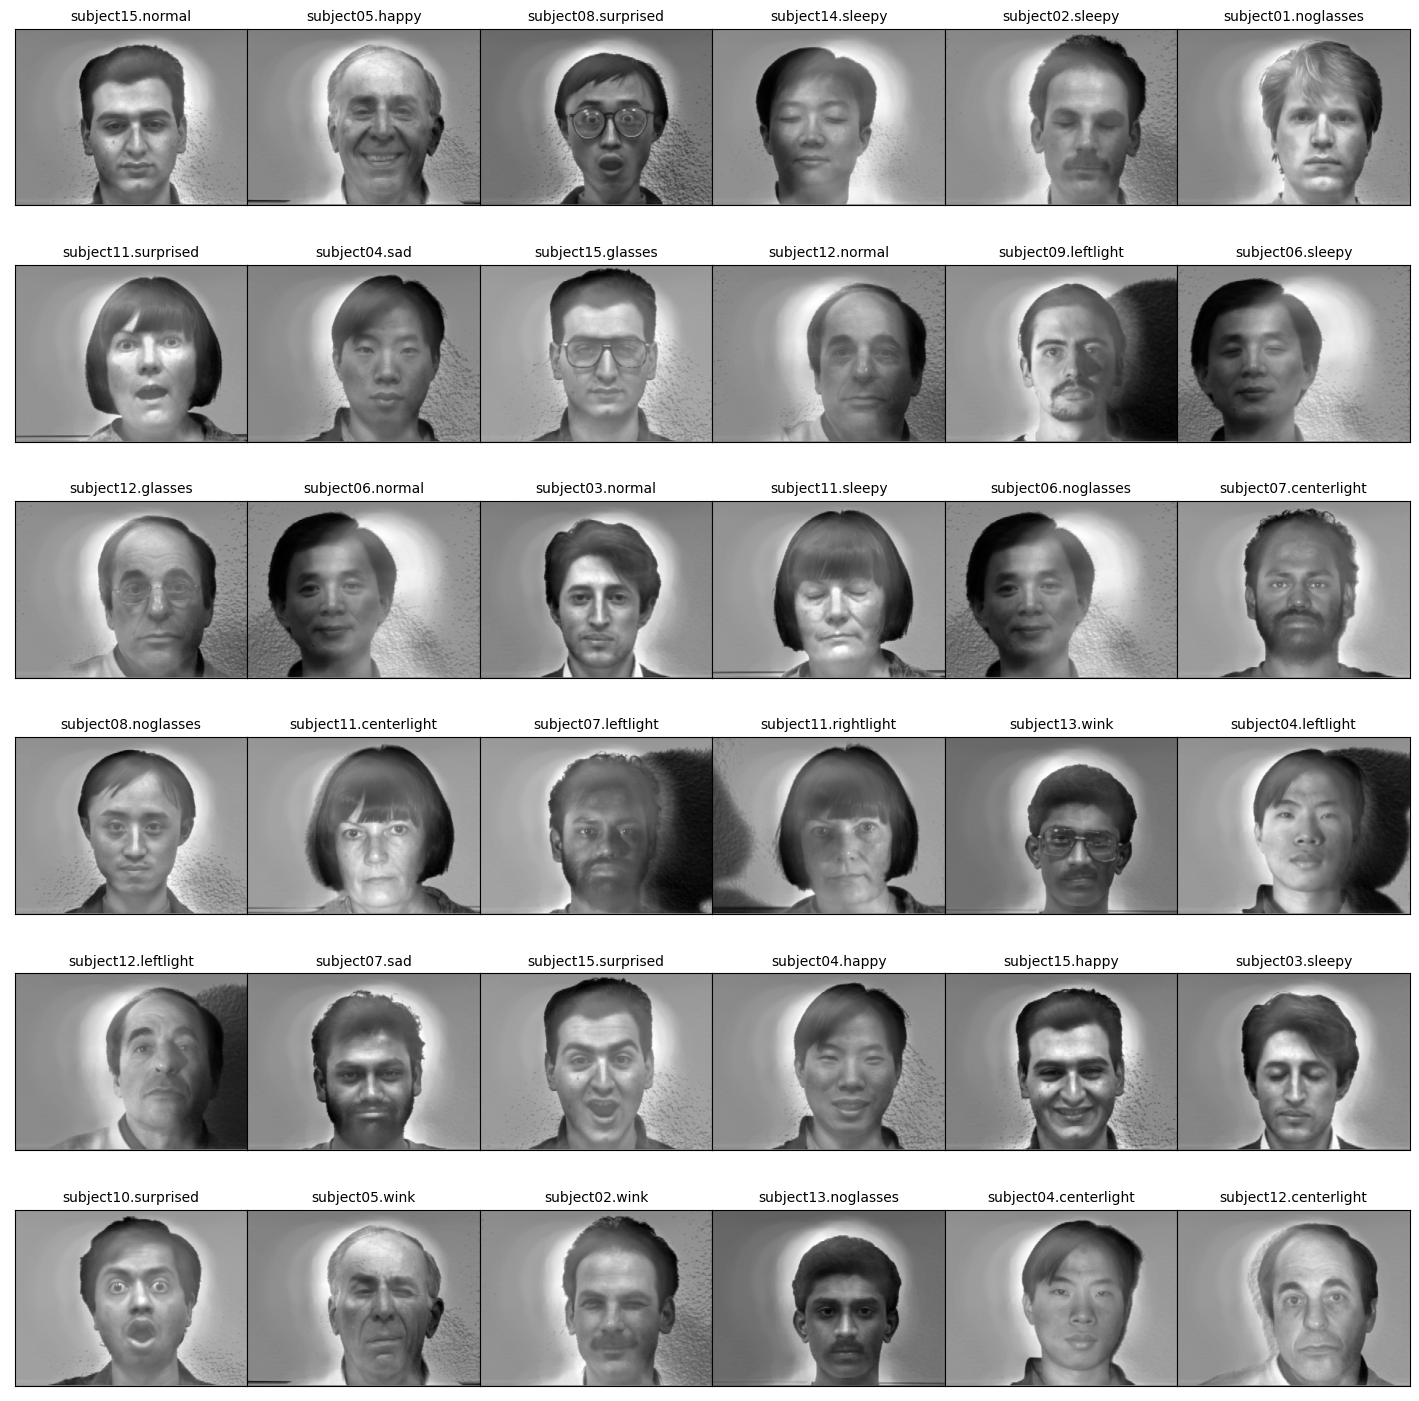

In [ ]:
plt.figure(figsize = (18, 18))
for img in range(0, 36):
    plt.subplot(6, 6, img + 1)
    plt.imshow(vec2img(A_shuffled[:,img]), cmap = "gray")
    plt.title(files_shuffled[img], fontsize = 10)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace = 0, hspace = 0.15)

## <a name="Section-34">3.4 Dividing Ratio</a>

#### __We decided to divide the data set into two disjoint sets in the ratio 75:25. This means that the size of the training set is 123.__

In [ ]:
# Select ratio
ratio = 0.75

totalColumns = A_shuffled.shape[1]
trainSize = int(totalColumns * ratio)
print(f"Training size : {trainSize}")

Training size : 123


## <a name="Section-35">3.5 Two Disjoint Sets $F$ and $Q$</a>

In [ ]:
# Database F
F = F_original = A_shuffled[:,:trainSize]
F_labels = F_original_labels = files_shuffled[:trainSize]

# Only individual names without a postfix in the lables of F are left
F_original_labels_subjects = []
for sub in F_labels:
    F_original_labels_subjects.append(sub[:9])
F_labels = F_original_labels_subjects


# Query set Q
Q = Q_original = A_shuffled[:,trainSize:]
Q_labels = Q_original_labels = files_shuffled[trainSize:]

In [ ]:
# F and Q dimensions
print(f"F : {F.shape}")
print(f"Q : {Q.shape}")

F : (77760, 123)
Q : (77760, 42)


# <a name="Section-4">4 Face Recognition in the Original Image Space</a>
[top](#Contents)

## <a name="Section-41">4.1 Definition of 'query'</a>

In [ ]:
def query(face, database):
    '''
        The 1 Nearest-Neighbor (1-N-N) Classifier
    '''
    bigEpsilon = np.linalg.norm(np.multiply(face.reshape(face.shape[0], 1), np.ones(database.shape)) - database, axis = 0)
    minimumValueIndex = np.argmin(bigEpsilon)

    id = F_labels[minimumValueIndex][:9]
    return id

## <a name="Section-42">4.2 Definition of 'recognition'</a>

In [ ]:
def recognition(querySetQ, DatabaseF, pictures = True, print_report = True):
    '''
        This function receives a batch of images and
        then calls the 'query' function which sequentially predicts image by image.
    '''
    # Only individual names without a postfix in the lables of F are left
    files_subjects = []
    for sub in files:
        files_subjects.append(sub[:9])

    outcome = 0
    numberImages = querySetQ.shape[1]

    for q in range(0, querySetQ.shape[1]):

        prediction = query(querySetQ[:,q], DatabaseF)
        # print(f"prediction = {prediction}")

        predictedPositionOriginal = files_subjects.index(prediction)
        # print(f"pQ_labels[q] = {Q_labels[q]}")
        
        positionQinOriginal = files.index(Q_labels[q])

        titleQ = Q_labels[q]
        titlePredict = files_subjects[predictedPositionOriginal]

        if titleQ[:9] == titlePredict[:9]:
            # print(f"{titleQ[:9]} == {titlePredict[:9]}")
            outcome += 1
        
        if pictures == True:
            # Plot
            plt.figure(figsize = (7, 15))

            plt.subplot(1, 2, 1)
            plt.imshow(gifs[positionQinOriginal], cmap = "gray")
            plt.title(titleQ  + " (Queried)", fontsize = 10)
            plt.xticks([])
            plt.yticks([])

            plt.subplot(1, 2, 2)
            plt.imshow(gifs[predictedPositionOriginal], cmap = "gray")
            plt.title(titlePredict + " (Predicted)", fontsize = 10)
            plt.xticks([])
            plt.yticks([])
            plt.subplots_adjust(wspace = 0)
                
            plt.show()

    if print_report == True:
        print(f"Number of Queried Pictures : {numberImages}")
        print(f"Number of Matches : {outcome}")
        print(f"Subject Accuracy : {np.round(outcome / numberImages * 100, 2)}%")
    else:
        return outcome / numberImages * 100

## <a name="Section-43">4.3 One Face Recognition</a>

prediction = subject02


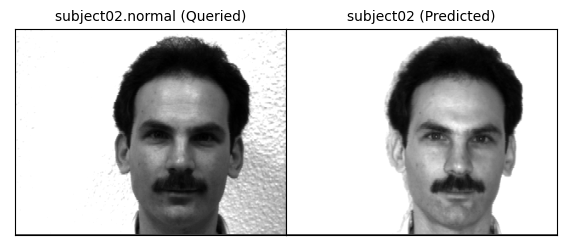

Number of Queried Pictures : 1
Number of Matches : 1
Subject Accuracy : 100.0%
The closest match in the database F is subject02.

Maximum Memory Usage (RAM): 146.01928424835205 MB
Execution time: 0:00:00.175953 [hh:mm:ss]


In [ ]:
numberImage = 1 # max. faces : 42
onePicture = Q[:,0:numberImage].reshape(Q[:,0:numberImage].shape[0], numberImage)

starting_time = time.time()

# starting the monitoring
tracemalloc.clear_traces()
tracemalloc.start()

id = query(onePicture, F)
recognition(onePicture, F)
print(f"The closest match in the database F is {id}.")

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1]/ (1024 * 1024)} MB")
tracemalloc.clear_traces()

print(f'Execution time: {timedelta(seconds = (time.time() - starting_time)*0.5)} [hh:mm:ss]')

## <a name="Section-44">4.4 Several Face Recognitions</a>

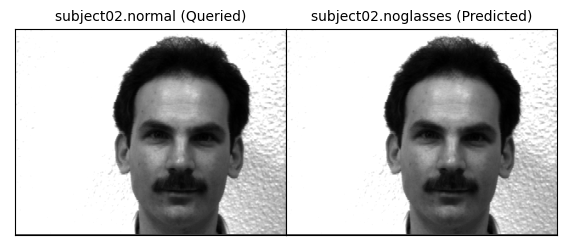

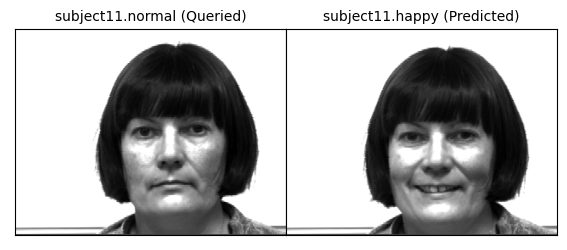

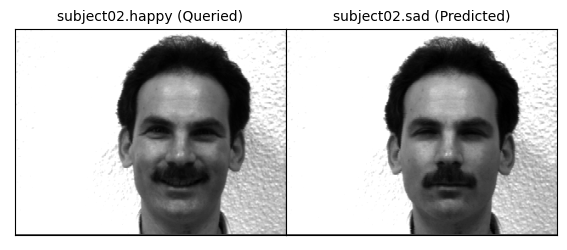

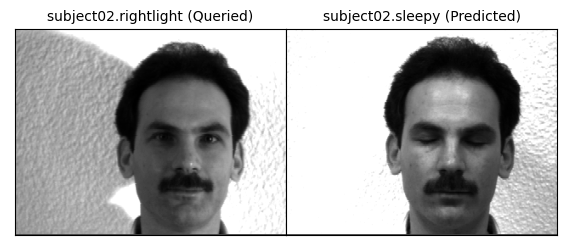

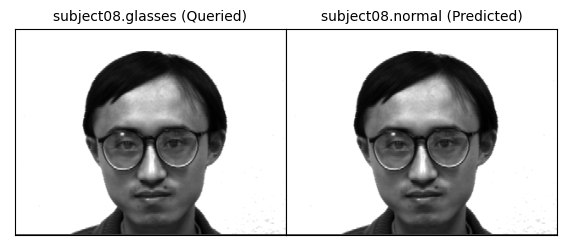

Number of Queried Pictures : 5
Number of Matches : 5
Subject Accuracy : 100.0%

Maximum Memory Usage (RAM): 147.69338512420654 MB
Execution time: 0:00:01.441139 [hh:mm:ss]


In [ ]:
numberImage = 5 # max. faces : 42

starting_time = time.time()

# starting the monitoring
tracemalloc.clear_traces()
tracemalloc.start()

recognition(Q[:,0:numberImage].reshape(Q[:,0:numberImage].shape[0], numberImage), F)

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1]/ (1024 * 1024)} MB")
tracemalloc.clear_traces()

print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

# <a name="Section-5">5 Recognition of each Image in $Q$</a>
[top](#Contents)

## <a name="Section-51">5.1 Original Ratio 75:25 between $F$ and $Q$</a>

In [ ]:
# Select ratio
ratio = 0.75

totalColumns = A_shuffled.shape[1]
trainSize = int(totalColumns * ratio)
print(f"Training size : {trainSize}")

Training size : 123


In [ ]:
# Database F
F = A_shuffled[:,:trainSize]
F_labels = files_shuffled[:trainSize]

# Query set Q
Q = A_shuffled[:,trainSize:]
Q_labels = files_shuffled[trainSize:]

In [ ]:
starting_time = time.time()

# starting the monitoring
tracemalloc.clear_traces()
tracemalloc.start()

recognition(Q, F, pictures = False)

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1]/ (1024 * 1024)} MB")
tracemalloc.clear_traces()

print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

Number of Queried Pictures : 42
Number of Matches : 35
Subject Accuracy : 83.33%

Maximum Memory Usage (RAM): 146.0098533630371 MB
Execution time: 0:00:03.564304 [hh:mm:ss]


## <a name="Section-52">5.2 Ration 80:20 between $F$ and $Q$</a>

In [ ]:
# Select ratio
ratio = 0.8

totalColumns = A_shuffled.shape[1]
trainSize = int(totalColumns * ratio)
print(f"Training size : {trainSize}")

Training size : 132


In [ ]:
# Database F
F = A_shuffled[:,:trainSize]
F_labels = files_shuffled[:trainSize]

# Query set Q
Q = A_shuffled[:,trainSize:]
Q_labels = files_shuffled[trainSize:]

In [ ]:
starting_time = time.time()

# starting the monitoring
tracemalloc.clear_traces()
tracemalloc.start()

recognition(Q, F, pictures = False)

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1]/ (1024 * 1024)} MB")
tracemalloc.clear_traces()

print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

Number of Queried Pictures : 33
Number of Matches : 28
Subject Accuracy : 84.85%

Maximum Memory Usage (RAM): 156.68852710723877 MB
Execution time: 0:00:03.074596 [hh:mm:ss]


## <a name="Section-53">5.3 Ration 60:40 between $F$ and $Q$</a>

In [ ]:
# Select ratio
ratio = 0.6

totalColumns = A_shuffled.shape[1]
trainSize = int(totalColumns * ratio)
print(f"Training size : {trainSize}")

Training size : 99


In [ ]:
# Database F
F = A_shuffled[:,:trainSize]
F_labels = files_shuffled[:trainSize]

# Query set Q
Q = A_shuffled[:,trainSize:]
Q_labels = files_shuffled[trainSize:]

In [ ]:
# starting the monitoring
starting_time = time.time()
tracemalloc.clear_traces()
tracemalloc.start()

recognition(Q, F, pictures = False)

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1]/ (1024 * 1024)} MB")
tracemalloc.clear_traces()

print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

Number of Queried Pictures : 66
Number of Matches : 52
Subject Accuracy : 78.79%

Maximum Memory Usage (RAM): 117.5323543548584 MB
Execution time: 0:00:04.763886 [hh:mm:ss]


## <a name="Section-54">5.4 Comparison of Individual Ratios</a>

#### __For individual ratios, it can be clearly observed that with a larger ratio for set F, the prediction is more accurate and vice versa. The prediction accuracy for individual ratios is as follows: 78.79% (60:40), 83.33% (75:25), and 84.85% (80:20).__

# <a name="Section-6">6 Singular Value Decomposition (SVD)</a>
[top](#Contents)

## <a name="Section-61">6.1 Original Ratio between $F$ and $Q$</a>

In [ ]:
# Database F
F = F_original
F_labels = F_original_labels

# Query set Q
Q = Q_original
Q_labels = Q_original_labels
print(f"Training size : {F.shape[1]}")

Training size : 123


## <a name="Section-62">6.2 SVD Calculation</a>

#### __We have decided to calculate the SVD of the $F$ database and not the whole data set including the query set $Q$. The reason is given that we develop this algorithm to be deployed for use in the real world in real-time. The query set $Q$ is our testing set where we want to get to know the accuracy of new examples that are not occupied in the database $F$.__

#### __We initially used the full numpy.linalg.svd for the purposes of SVD calculation and approximation. After calling this function, this function immediately started to fill the computer's operating memory (32GB), then the SSD started to work at 100% and after about 5 minutes of calculation, the computer stopped responding to any commands. After researching the scientific article "Facial Recognition with Singular Value Decomposition" (The Golub-Reinsch Algorithm was used), we found that we can use the reduced SVD which does not require a lot of operation memory.__

#### __There is an alternative library called Dask library. This library has been developed to handle even large matrices with more than 10000 parameters. This library is very versatile with support of computer parallelism. For this reason, we chose SVD from the Dask library, specifically its NumPy equivalent called Array. This library computes the reduced SVD of the matrix F approximately in 47 milliseconds compare to NumPy reduced SVD which can compute the same in 935 milliseconds (approx. 20 times slower).__

### Numpy reduced SVD

In [ ]:
# starting the monitoring
starting_time = time.time()
tracemalloc.clear_traces()
tracemalloc.start()

U, Sigma, Vt = np.linalg.svd(F, full_matrices=False)

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1] / (1024 * 1024)} MB")
tracemalloc.clear_traces()
print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')


Maximum Memory Usage (RAM): 73.1014757156372 MB
Execution time: 0:00:01.263223 [hh:mm:ss]


### Dask reduced SVD

In [ ]:
a = da.from_array(F)

# starting the monitoring
starting_time = time.time()
tracemalloc.start()

# u, sigma, vt = da.linalg.svd(a)
u, sigma, vt = da.linalg.svd_compressed(a, F.shape[1])

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1] / (1024 * 1024)} MB")
tracemalloc.clear_traces()
print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')


Maximum Memory Usage (RAM): 0.6948003768920898 MB
Execution time: 0:00:00.053894 [hh:mm:ss]


In [ ]:
U, Sigma, Vt = np.array(u), np.array(sigma), np.array(vt)

#### __If the NumPy array is used for numerical calculations in the entire program, then using the Dask Library loses all the advantages of speed and efficiency. This is caused by converting the resulting structures into NumPy arrays, which is time-consuming.__

## <a name="Section-63">6.3 Sanity Check on Dimensions</a>

In [ ]:
# Sanity check on dimensions
print(f"F: {F.shape}")
print(f"U: {U.shape}")
print(f"Σ: {Sigma.shape}")
print(f"Vᵀ: {Vt.shape}")
print(f"UΣVᵀ: {(U @ np.diag(Sigma) @ Vt).shape}")

F: (77760, 123)
U: (77760, 123)
Σ: (123,)
Vᵀ: (123, 123)
UΣVᵀ: (77760, 123)


## <a name="Section-64">6.4 Eigen Faces</a>

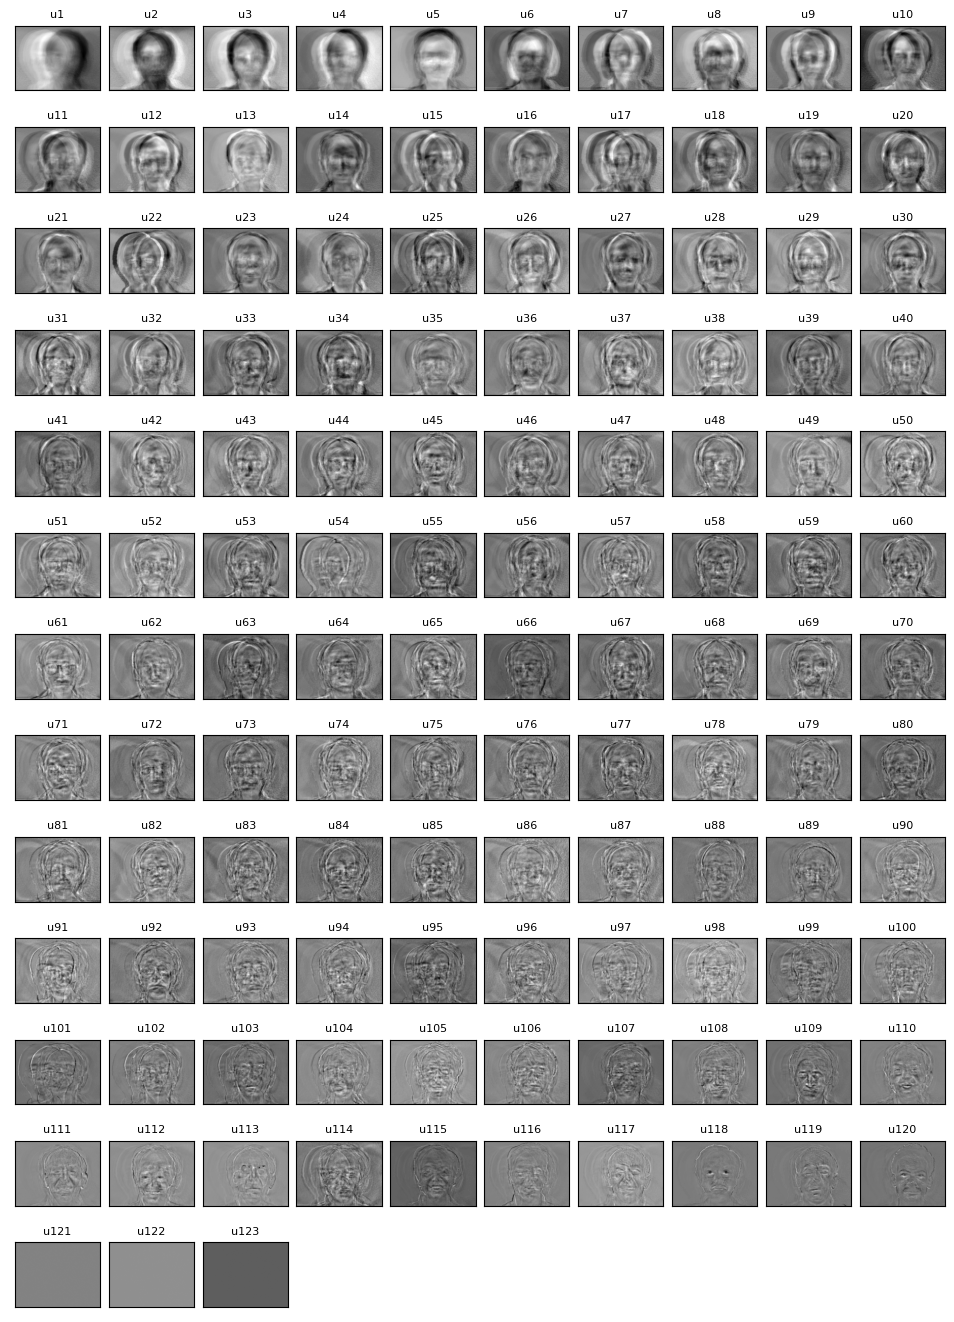

In [ ]:
#Plot of "Eigen Faces"
plt.figure(figsize = (12, 17))
for img in range(0, U.shape[1]):
    plt.subplot(13, 10, img + 1)
    plt.imshow(vec2img(U[:,img]), cmap = "gray")
    plt.title(f"u{img+1}", fontsize = 8)
    plt.xticks([]) 
    plt.yticks([])
    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)

# <a name="Section-7">7 Selection of the Dimension $p$</a>
[top](#Contents)

## <a name="Section-71">7.1 Distribution of Singular Values</a>

In [ ]:
p = range(1, len(Sigma)+1)
CumSum = np.cumsum(Sigma)/np.sum(Sigma)

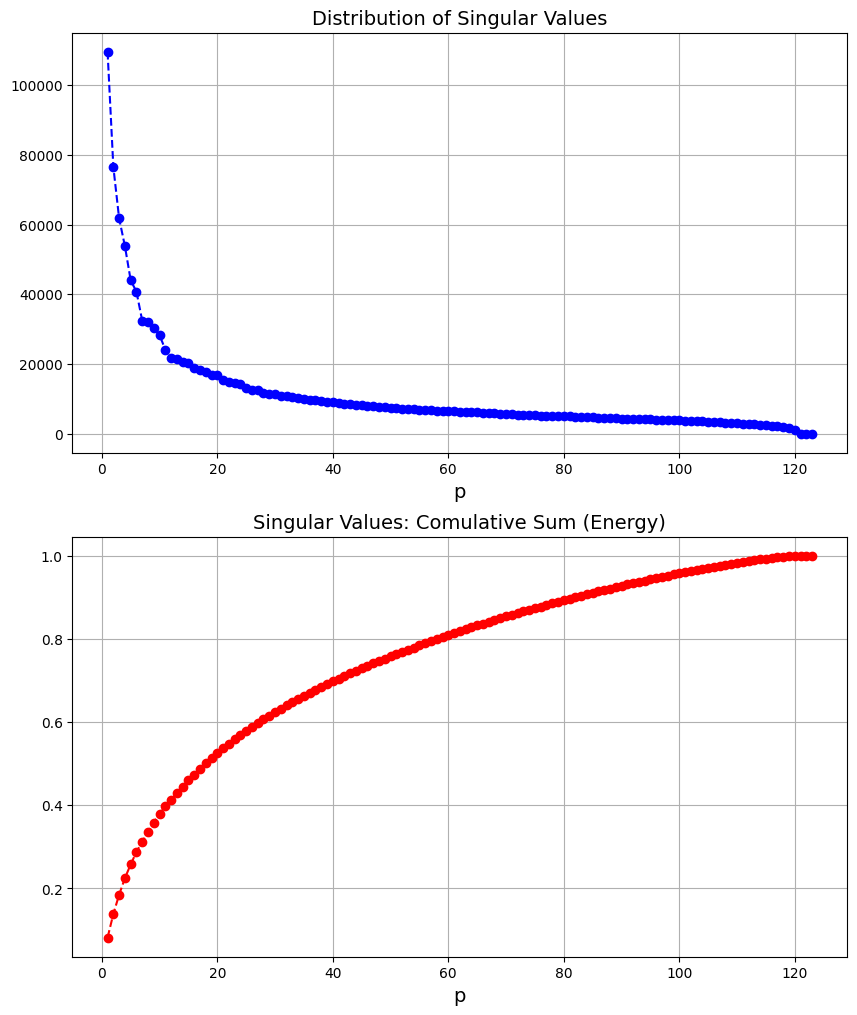

In [ ]:
# Plot
plt.figure(figsize = (10, 12))
plt.subplot(2, 1, 1)
plt.plot(p, Sigma, 'bo--')
plt.title(f"Distribution of Singular Values", fontsize = 14)
plt.xlabel('p', fontsize = 14)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(p, CumSum, 'ro--')
plt.title(f"Singular Values: Comulative Sum (Energy)", fontsize = 14)
plt.xlabel('p', fontsize = 14)
plt.grid()
plt.show()

## <a name="Section-72">7.2 Value of $p$</a>

In [ ]:
# 50% of the Comulative Sum
p50 = 0.5
index = np.absolute(CumSum - p50).argmin()
selected_dimension_p = p[index]
print(f"p = {selected_dimension_p}")

p = 18


### __We decided to choose $p = 18$ because with this value we have 50% of the cumulative sum (energy) of the singular values.__

# <a name="Section-8">8 Projection on the Reduced Face Space</a>
[top](#Contents)

## <a name="Section-81">8.1 Base-Face</a>

In [ ]:
U_base = U[:,:selected_dimension_p]

# Dimensionality check
print(f"U_base : {U_base.shape}")

U_base : (77760, 18)


## <a name="Section-82">8.2 Projection of the Database $F$</a>

In [ ]:
F_reduced = U_base.T @ F

# Dimensionality check
print(f"F_reduced : {F_reduced.shape}")

F_reduced : (18, 123)


## <a name="Section-83">8.3 Projection of the Query Set $Q$</a>

In [ ]:
Q_reduced = U_base.T @ Q

# Dimensionality check
print(f"Q_reduced : {Q_reduced.shape}")

Q_reduced : (18, 42)


## <a name="Section-84">8.4 Recognition of the Reduced $Q$</a>

In [ ]:
# starting the monitoring
starting_time = time.time()
tracemalloc.clear_traces()
tracemalloc.start()

recognition(Q_reduced, F_reduced, pictures = False)

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1]/ (1024 * 1024)} MB")
tracemalloc.clear_traces()

print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

Number of Queried Pictures : 42
Number of Matches : 30
Subject Accuracy : 71.43%

Maximum Memory Usage (RAM): 0.05500507354736328 MB
Execution time: 0:00:00.076794 [hh:mm:ss]


### __The new accuracy in the reduced Q set is 71.43%, which represents a decrease in accuracy compared to the unreduced Q set by approximately 12% from 83.33%.__

## <a name="Section-85">8.5 One Face Recognition of the reduced $Q$</a>

In [ ]:
numberImage = 1
onePicture = Q_reduced[:,0:numberImage].reshape(Q_reduced[:,0:numberImage].shape[0], numberImage)

# starting the monitoring
starting_time = time.time()
tracemalloc.clear_traces()
tracemalloc.start()

recognition(onePicture, F_reduced, pictures = False)

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1]/ (1024 * 1024)} MB")
tracemalloc.clear_traces()
print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

Number of Queried Pictures : 1
Number of Matches : 1
Subject Accuracy : 100.0%

Maximum Memory Usage (RAM): 0.053920745849609375 MB
Execution time: 0:00:00.000999 [hh:mm:ss]


## <a name="Section-86">8.6 Accuracy Based on $p$</a>

In [ ]:
P = list(range(1, F.shape[1] + 1))[::-1]
accuracy = []

for p in P:
    U_base = U[:,:p]
    F_reduced = U_base.T @ F
    Q_reduced = U_base.T @ Q
    accuracy.append(recognition(Q_reduced, F_reduced, pictures = False, print_report = False))

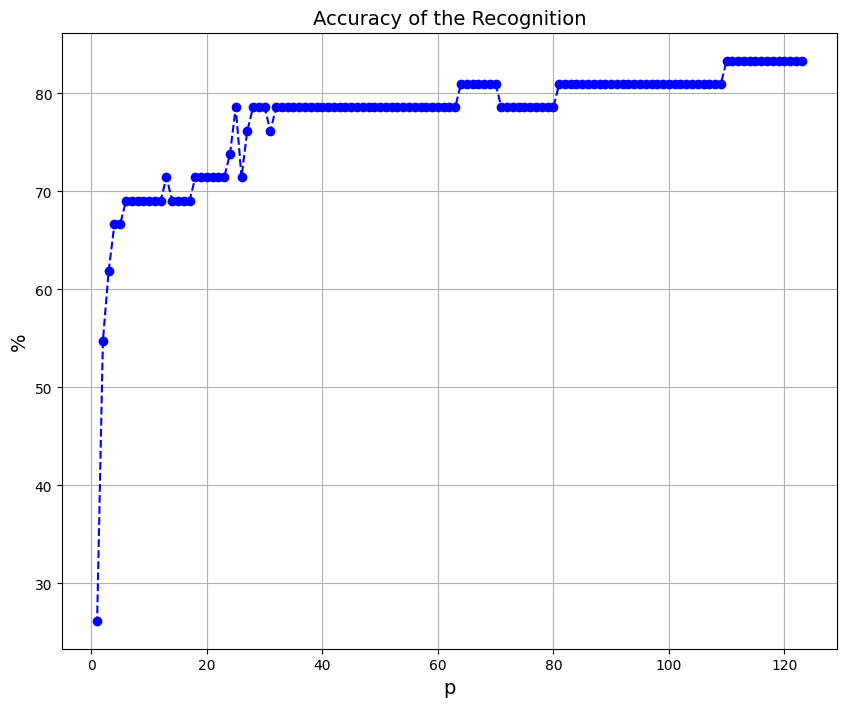

In [ ]:
# Plot
plt.figure(figsize = (10, 8))
plt.plot(P, accuracy, 'bo--')
plt.title(f"Accuracy of the Recognition", fontsize = 14)
plt.xlabel('p', fontsize = 14)
plt.ylabel('%', fontsize = 14)
plt.grid()
plt.show()

### __The given graph is based on the change in p from the value 1 to the value 123 (unreduced F). It can be observed that as p changes, so does the accuracy, and in general, it can be said that the higher the p, the higher the accuracy. There are some exceptions to this statement that can be seen in the thesis graph.__

# <a name="Section-9">9 Conclusion</a>
[top](#Contents)

### __In our project, time or memory efficiency did not play a crucial role, so in our case, we would not use SVD to reduce dimensionality. However, we can imagine applications where time and memory efficiency play a high role, and then it would be appropriate to use SVD. This can occur in applications where computing power is very expensive or timing is critical. It can be different security systems with an emphasis on time efficiency or systems with low demand for computing performance.__

# <a name="Section-10">10 Extra Activities</a>
[top](#Contents)

## <a name="Section-101">10.1 Personal Implementation of SVD</a>

In [ ]:
def SVD(A):
    '''
        SVD : Singular Value Decomposition
    '''
    # AᵀA
    AtA = A.T @ A

    # Eigen values and eigen vectors of AᵀA
    S2, V = np.linalg.eig(AtA)

    # Vᵀ
    Vt = V.T

    # Singular values
    S = np.sqrt(S2)

    # U = A V
    U = A @ V

    # Normalization of U
    U = U/ np.linalg.norm(U, 2, axis=0)

    return U, S, Vt

In [ ]:
# starting the monitoring
starting_time = time.time()
tracemalloc.clear_traces()
tracemalloc.start()

u, s, vt = SVD(F)

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1]/ (1024 * 1024)} MB")
tracemalloc.clear_traces()
print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')


Maximum Memory Usage (RAM): 438.1795129776001 MB
Execution time: 0:00:00.319265 [hh:mm:ss]


In [ ]:
# Sanity check on dimensions
print(f"F: {F.shape}")
print(f"u: {u.shape}")
print(f"s: {s.shape}")
print(f"vᵀ: {vt.shape}")
print(f"usvᵀ: {(u @ np.diag(s) @ vt).shape}")

F: (77760, 123)
u: (77760, 123)
s: (123,)
vᵀ: (123, 123)
usvᵀ: (77760, 123)


### __Compared to the SVD of standard libraries such as Numpy or Dask, our SVD implementation with 375 milliseconds is among the SVD of these libraries. In terms of RAM consumption, it is the worst with 438 MB. From the point of view of the consumption of operating memory, it would be necessary to think about the optimization of the mentioned implementation. One candidate for this implementation can be Randomized Singular Value Decomposition by N. Halko, P. Martinsson, and J. A. Tropp published in 2009.__

## <a name="Section-102">10.2 Average Face of Each Individual in $F$</a>

#### __Because we do not want to use the normalized sets F and Q, we shuffle the original dataset, dividing it into non-normalized sets $F$ and $Q$.__

In [ ]:
# Shuffle the original dataset 165 pictures
B_shuffled, B_files_shuffled = shuffle([dataSet[:,idx] for idx in range(dataSet.shape[1])], files)

In [ ]:
# Select ratio
ratio = 0.75

totalColumns = B_shuffled.shape[1]
trainSize = int(totalColumns * ratio)
print(f"Training size : {trainSize}")

Training size : 123


In [ ]:
# Database F
F = B_shuffled[:,:trainSize]
F_labels = B_files_shuffled[:trainSize]

# Query set Q
Q = B_shuffled[:,trainSize:]
Q_labels = B_files_shuffled[trainSize:]

In [ ]:
# List with names of each individuals
subjectCount = 15
subjectNames = ['subject' + f"{n:02d}" for n in range(1, subjectCount + 1)]
subjectNames[:5]

['subject01', 'subject02', 'subject03', 'subject04', 'subject05']

In [ ]:
# Only individual names without a postfix in the lables of F are left
F_original_labels_subjects = []
for sub in F_labels:
    F_original_labels_subjects.append(sub[:9])

In [ ]:
# Indexes of positions of individual subjects in F
indexesIndividuals = []
for sub in subjectNames:
        indices = [i for i,val in enumerate(F_original_labels_subjects) if val == sub]
        indexesIndividuals.append(indices)

In [ ]:
# Create a matrix with an average face for each individual
for idx, invidual in enumerate(indexesIndividuals):

    averageIndividualFace = 0
    for position in invidual:
        averageIndividualFace += F[:,position]

    # Average face of one individual
    averageIndividualFace = averageIndividualFace / len(invidual)
    averageIndividualFace = averageIndividualFace.reshape(averageIndividualFace.shape[0], 1)
   
    # Adding to each average face in the matrix
    if idx == 0:
        matrixAverageIndividuals = averageIndividualFace
    else:
        matrixAverageIndividuals = np.concatenate((matrixAverageIndividuals, averageIndividualFace), axis=1)


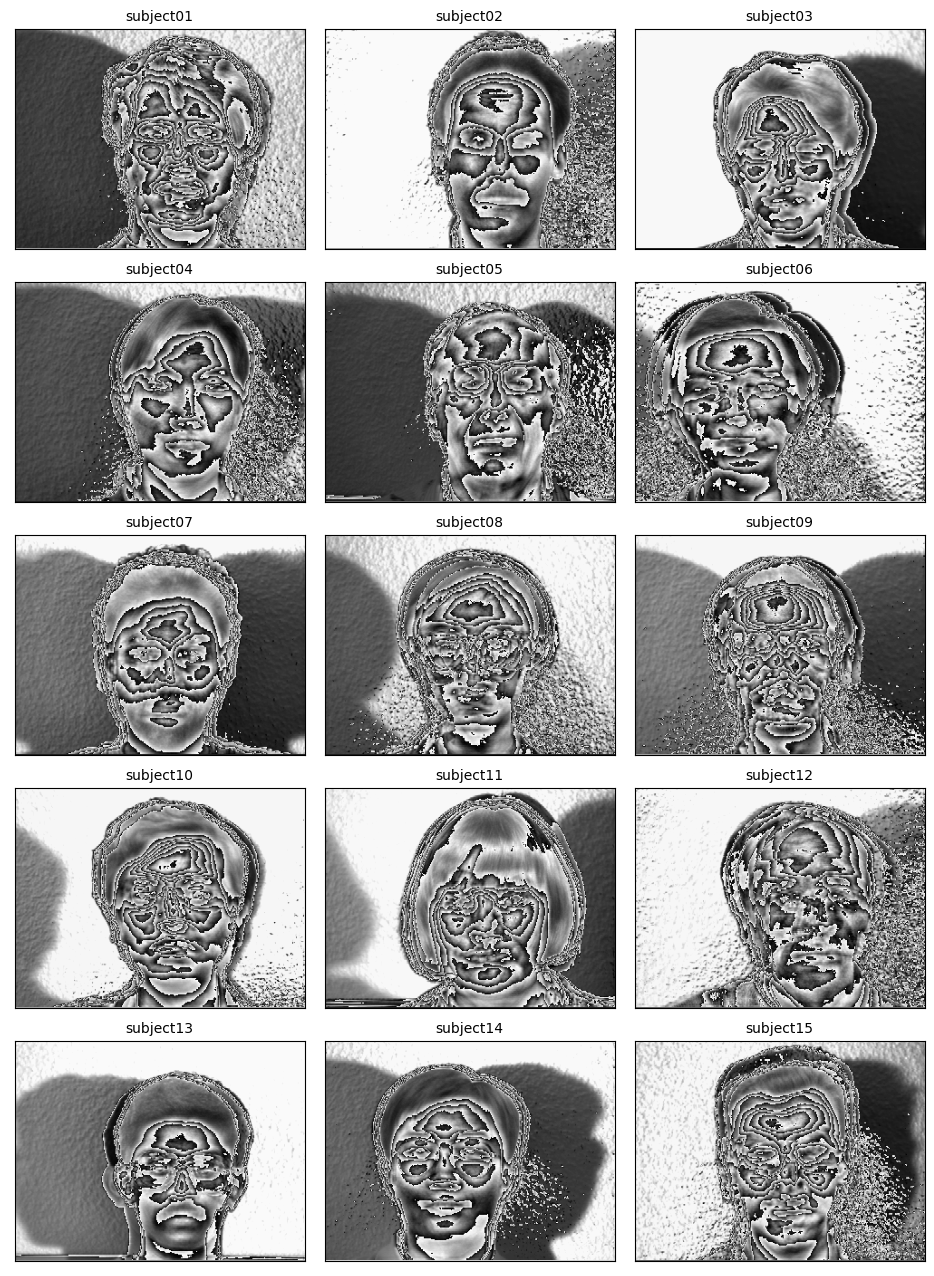

In [ ]:
# Plot of the average face for each individual
plt.figure(figsize = (12, 16))
for img in range(0, subjectCount):
    plt.subplot(5, 3, img + 1)
    plt.imshow(vec2img(matrixAverageIndividuals[:,img]), cmap = "gray")
    plt.title(subjectNames[img], fontsize = 10)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace = 0, hspace = 0.15)

In [ ]:
# Database F
F = matrixAverageIndividuals
F_labels = subjectNames
files = subjectNames

# Query set Q
Q = Q_original = A_shuffled[:,trainSize:]
Q_labels = Q_original_labels = files_shuffled[trainSize:]

In [ ]:
files

['subject01',
 'subject02',
 'subject03',
 'subject04',
 'subject05',
 'subject06',
 'subject07',
 'subject08',
 'subject09',
 'subject10',
 'subject11',
 'subject12',
 'subject13',
 'subject14',
 'subject15']

In [ ]:
# starting the monitoring
starting_time = time.time()
tracemalloc.clear_traces()
tracemalloc.start()

recognition(Q, F, pictures = False)

# displaying the memory
print(f"\nMaximum Memory Usage (RAM): {tracemalloc.get_traced_memory()[1]/ (1024 * 1024)} MB")
tracemalloc.clear_traces()

print(f'Execution time: {timedelta(seconds = time.time() - starting_time)} [hh:mm:ss]')

prediction = subject07
pQ_labels[q] = subject02.normal


ValueError: 'subject02.normal' is not in list

# <a name="Section-11">11 Summary of the Results</a>
[top](#Contents)

# <a name="Section-8">References</a>
[top](#Contents)

* __Large SVDs: https://blog.dask.org/2020/05/13/large-svds__
* __Measuring the allocated memory with tracemalloc: https://stackoverflow.com/questions/70525623/measuring-the-allocated-memory-with-tracemalloc__
* __Randomized Singular Value Decomposition; Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions, Nathan Halko, Per-Gunnar Martinsson, Joel A. Tropp, 2009 : https://arxiv.org/abs/0909.4061__